📊 Initial Dataset: 92 features, 39119 rows

🔒 Protected Features (Cannot be dropped): 11
   ✓ pl_name
   ✓ hostname
   ✓ pl_rade
   ✓ pl_bmasse
   ✓ pl_eqt
   ✓ pl_orbper
   ✓ pl_orbsmax
   ✓ st_spectype
   ✓ st_teff
   ✓ st_met
   ✓ st_rad

✓ Calculated pl_density (ADDED TO MUST-HAVE)
✓ Calculated st_luminosity (ADDED TO MUST-HAVE)

📊 Handling Duplicate Planets:
Original rows: 39119
Duplicate planet entries found: 38234

Sample duplicates:
    pl_name hostname  default_flag
0  11 Com b   11 Com             1
1  11 Com b   11 Com             0
2  11 Com b   11 Com             0
3  11 UMi b   11 UMi             0
4  11 UMi b   11 UMi             1
5  11 UMi b   11 UMi             0
6  14 And b   14 And             0
7  14 And b   14 And             1
8  14 And b   14 And             0
9  14 Her b   14 Her             1

🔧 Aggregation Strategy:
   1. Keep rows with default_flag = 1
   2. For remaining duplicates, aggregate using median (numeric) and mode (categorical)

✓ After deduplicat

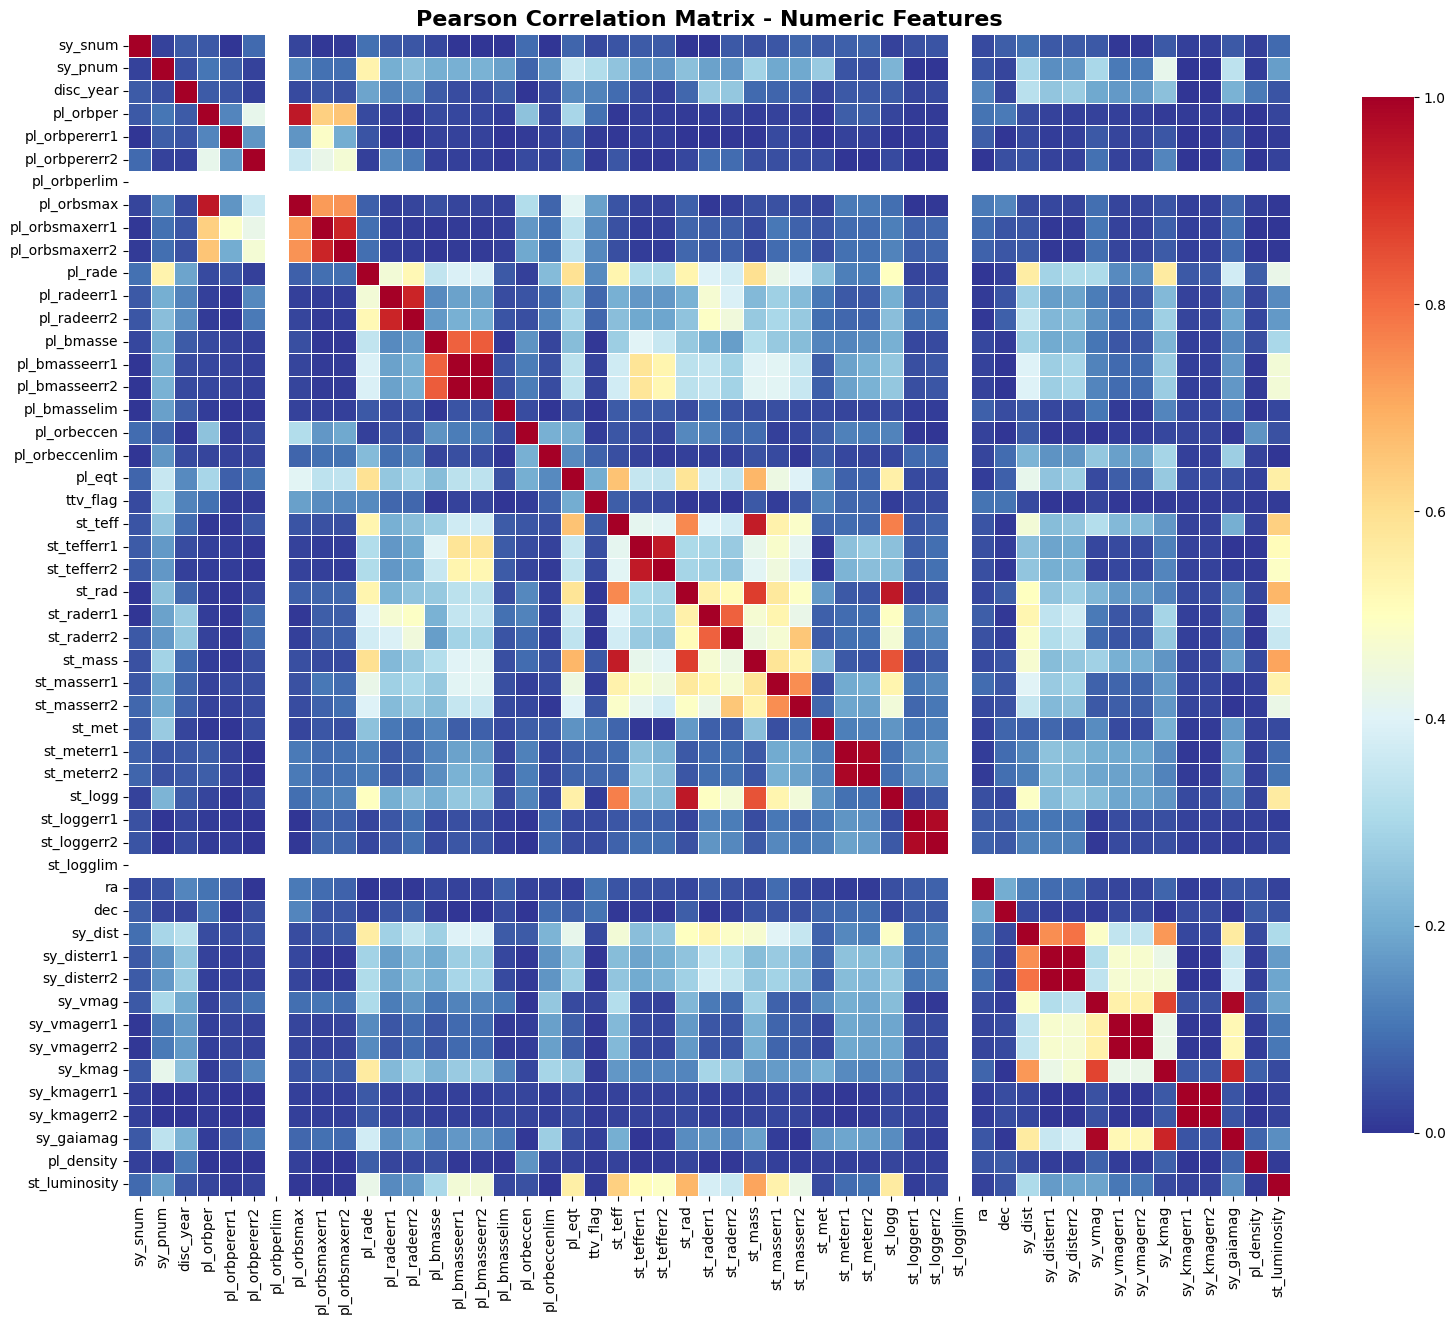


⚠️  Found 7 highly correlated pairs (>0.95):
    Feature_1     Feature_2  Correlation
pl_bmasseerr1 pl_bmasseerr2     0.997881
   st_meterr1    st_meterr2     0.985211
  st_loggerr1   st_loggerr2     0.977774
  sy_disterr1   sy_disterr2     0.996151
      sy_vmag    sy_gaiamag     0.987576
  sy_vmagerr1   sy_vmagerr2     1.000000
  sy_kmagerr1   sy_kmagerr2     1.000000

🗑️  Features to drop: 7
   - pl_bmasseerr2
   - st_loggerr2
   - st_meterr2
   - sy_disterr2
   - sy_gaiamag
   - sy_kmagerr2
   - sy_vmagerr2

✓ Dropped 7 highly correlated features

📊 HANDLING MISSING VALUES - Must-Have Features

Missing values in must-have features:
   pl_name: 0 (0.00%)
   hostname: 0 (0.00%)
   pl_rade: 1548 (25.58%)
   pl_bmasse: 3082 (50.93%)
   pl_eqt: 4421 (73.05%)
   pl_orbper: 326 (5.39%)
   pl_orbsmax: 2280 (37.67%)
   st_spectype: 4771 (78.83%)
   st_teff: 697 (11.52%)
   st_met: 1770 (29.25%)
   st_rad: 779 (12.87%)
   pl_density: 4610 (76.17%)
   st_luminosity: 895 (14.79%)

🔧 Imputatio

/tmp/ipython-input-2731342024.py:316: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_value, inplace=True)
/tmp/ipython-input-2731342024.py:311: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

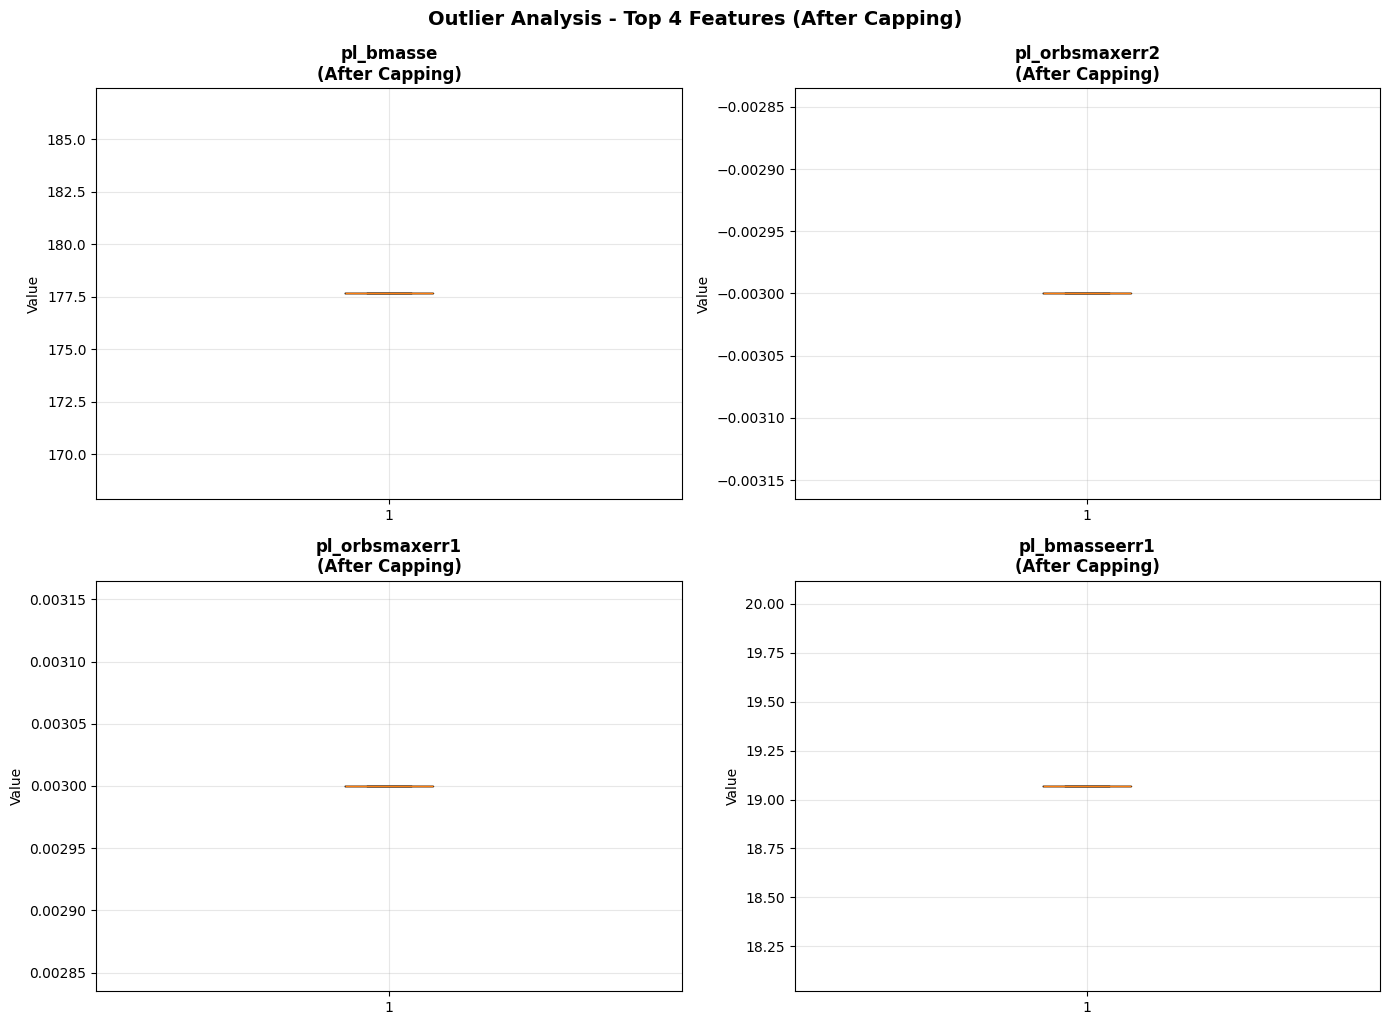


📊 FINAL SUMMARY

Dataset Shape: 6052 rows × 51 columns

✅ Must-Have Features Retained (13):
   ✓ pl_name
   ✓ hostname
   ✓ pl_rade
   ✓ pl_bmasse
   ✓ pl_eqt
   ✓ pl_orbper
   ✓ pl_orbsmax
   ✓ st_spectype
   ✓ st_teff
   ✓ st_met
   ✓ st_rad
   ✓ pl_density
   ✓ st_luminosity

📋 All Final Features (51):
   - pl_name (Categorical) 🔒 MUST-HAVE
   - hostname (Categorical) 🔒 MUST-HAVE
   - sy_snum (Numeric) 
   - sy_pnum (Numeric) 
   - discoverymethod (Categorical) 
   - disc_year (Numeric) 
   - disc_facility (Categorical) 
   - pl_orbper (Numeric) 🔒 MUST-HAVE
   - pl_orbpererr1 (Numeric) 
   - pl_orbpererr2 (Numeric) 
   - pl_orbperlim (Numeric) 
   - pl_orbsmax (Numeric) 🔒 MUST-HAVE
   - pl_orbsmaxerr1 (Numeric) 
   - pl_orbsmaxerr2 (Numeric) 
   - pl_rade (Numeric) 🔒 MUST-HAVE
   - pl_radeerr1 (Numeric) 
   - pl_radeerr2 (Numeric) 
   - pl_bmasse (Numeric) 🔒 MUST-HAVE
   - pl_bmasseerr1 (Numeric) 
   - pl_bmasselim (Numeric) 
   - pl_bmassprov (Categorical) 
   - pl_orbeccen (Numer

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr

# Load your dataset
df = pd.read_csv('//content//PS_2025.12.01_05.00.30.csv', comment='#')

print(f"📊 Initial Dataset: {df.shape[1]} features, {df.shape[0]} rows")

# ============================================
# STEP 1: Define MUST-HAVE Features (Protected)
# ============================================

MUST_HAVE_FEATURES = [
    # Planet properties (REQUIRED - CANNOT BE DROPPED)
    'pl_name',           # Identifier
    'hostname',          # Identifier
    'pl_rade',           # Planet radius (Earth radii)
    'pl_bmasse',         # Planet mass (Earth mass)
    'pl_eqt',            # Surface/equilibrium temperature
    'pl_orbper',         # Orbital period
    'pl_orbsmax',        # Distance from star (semi-major axis)

    # Star properties (REQUIRED - CANNOT BE DROPPED)
    'st_spectype',       # Star type
    'st_teff',           # Star temperature
    'st_met',            # Star metallicity
    'st_rad',            # Star radius (for luminosity calculation)
]

print(f"\n🔒 Protected Features (Cannot be dropped): {len(MUST_HAVE_FEATURES)}")
for feat in MUST_HAVE_FEATURES:
    if feat in df.columns:
        print(f"   ✓ {feat}")
    else:
        print(f"   ✗ {feat} - NOT FOUND IN DATASET!")

# ============================================
# STEP 2: Calculate Missing Features
# ============================================

# Planet Density (g/cm³)
if 'pl_bmasse' in df.columns and 'pl_rade' in df.columns:
    df['pl_density'] = (df['pl_bmasse'] / (df['pl_rade'] ** 3)) * 5.514
    MUST_HAVE_FEATURES.append('pl_density')
    print("\n✓ Calculated pl_density (ADDED TO MUST-HAVE)")

# Stellar Luminosity (Solar luminosities)
if 'st_rad' in df.columns and 'st_teff' in df.columns:
    T_sun = 5772
    df['st_luminosity'] = (df['st_rad'] ** 2) * ((df['st_teff'] / T_sun) ** 4)
    MUST_HAVE_FEATURES.append('st_luminosity')
    print("✓ Calculated st_luminosity (ADDED TO MUST-HAVE)")

# ============================================
# STEP 3: Handle Duplicate Rows (Same Planet Multiple Times)
# ============================================

print(f"\n📊 Handling Duplicate Planets:")
print(f"Original rows: {df.shape[0]}")

# Check for duplicates based on planet name
duplicates = df[df.duplicated(subset=['pl_name'], keep=False)]
print(f"Duplicate planet entries found: {len(duplicates)}")

if len(duplicates) > 0:
    print(f"\nSample duplicates:")
    print(duplicates[['pl_name', 'hostname', 'default_flag']].head(10))

    # Strategy: Keep only default parameter set (default_flag = 1)
    # If no default, aggregate using median for numeric, mode for categorical

    print("\n🔧 Aggregation Strategy:")
    print("   1. Keep rows with default_flag = 1")
    print("   2. For remaining duplicates, aggregate using median (numeric) and mode (categorical)")

    # First, keep all default parameter sets
    df_default = df[df['default_flag'] == 1].copy()

    # Find planets without default flag
    planets_with_default = df_default['pl_name'].unique()
    df_no_default = df[~df['pl_name'].isin(planets_with_default)].copy()

    # Aggregate duplicates without default flag
    if len(df_no_default) > 0:
        # Separate numeric and categorical columns
        numeric_cols = df_no_default.select_dtypes(include=[np.number]).columns
        categorical_cols = df_no_default.select_dtypes(include=['object']).columns

        # Aggregate numeric columns with median
        df_no_default_agg = df_no_default.groupby('pl_name')[numeric_cols].median()

        # Aggregate categorical columns with mode (first value)
        for col in categorical_cols:
            if col != 'pl_name':
                df_no_default_agg[col] = df_no_default.groupby('pl_name')[col].first()

        df_no_default_agg = df_no_default_agg.reset_index()

        # Combine default and aggregated
        df = pd.concat([df_default, df_no_default_agg], ignore_index=True)
    else:
        df = df_default

    print(f"\n✓ After deduplication: {df.shape[0]} rows")

# ============================================
# STEP 4: Drop Administrative/Metadata Columns
# ============================================

admin_columns = [
    'default_flag', 'pl_controv_flag', 'soltype',
    'pl_refname', 'st_refname', 'sy_refname',
    'rowupdate', 'pl_pubdate', 'releasedate',
    'rastr', 'decstr'
]

# Drop only if they exist and NOT in must-have list
admin_to_drop = [col for col in admin_columns if col in df.columns and col not in MUST_HAVE_FEATURES]
df = df.drop(columns=admin_to_drop)

print(f"\n✓ Dropped {len(admin_to_drop)} administrative columns")
print(f"Remaining features: {df.shape[1]}")

# ============================================
# STEP 5: Drop Duplicate Unit Columns
# ============================================

duplicate_columns = []

if 'pl_radj' in df.columns and 'pl_rade' in df.columns:
    duplicate_columns.extend(['pl_radj', 'pl_radjerr1', 'pl_radjerr2', 'pl_radjlim'])

if 'pl_bmassj' in df.columns and 'pl_bmasse' in df.columns:
    duplicate_columns.extend(['pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2', 'pl_bmassjlim'])

# Remove columns that don't exist
duplicate_columns = [col for col in duplicate_columns if col in df.columns]

df = df.drop(columns=duplicate_columns)
print(f"✓ Dropped {len(duplicate_columns)} duplicate unit columns")
print(f"Remaining features: {df.shape[1]}")

# ============================================
# STEP 6: Missing Values Analysis
# ============================================

print("\n📊 Missing Values Analysis:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing_Count': missing.values,
    'Missing_Percentage': missing_pct.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

print(missing_df.head(20).to_string(index=False))

# Drop columns with >70% missing (EXCEPT must-have features)
missing_threshold = 70
high_missing_cols = missing_df[missing_df['Missing_Percentage'] > missing_threshold]['Column'].tolist()
high_missing_cols = [col for col in high_missing_cols if col not in MUST_HAVE_FEATURES]

if len(high_missing_cols) > 0:
    df = df.drop(columns=high_missing_cols)
    print(f"\n✓ Dropped {len(high_missing_cols)} columns with >{missing_threshold}% missing")
    print(f"   (Protected must-have features from deletion)")
    print(f"Remaining features: {df.shape[1]}")

# ============================================
# STEP 7: Statistical Method - Variance Threshold
# ============================================

print("\n" + "="*70)
print("📊 STATISTICAL METHOD 1: Variance Threshold")
print("="*70)
print("Removes features with near-zero variance (almost constant values)")
print("Low variance = feature doesn't provide much information")

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

variances = df[numeric_cols].var()
low_var_threshold = 0.001
low_var_features = variances[variances < low_var_threshold].index.tolist()

# Don't drop must-have features
low_var_features = [col for col in low_var_features if col not in MUST_HAVE_FEATURES]

if len(low_var_features) > 0:
    print(f"\nLow Variance Features (< {low_var_threshold}):")
    for feat in low_var_features:
        print(f"   - {feat}: variance = {variances[feat]:.6f}")

    df = df.drop(columns=low_var_features)
    numeric_cols = [col for col in numeric_cols if col not in low_var_features]
    print(f"\n✓ Dropped {len(low_var_features)} low variance features")
else:
    print("\n✓ No low variance features found")

# ============================================
# STEP 8: Statistical Method - Pearson Correlation
# ============================================

print("\n" + "="*70)
print("📊 STATISTICAL METHOD 2: Pearson Correlation Coefficient")
print("="*70)
print("Measures linear relationship between two numeric variables")
print("Range: -1 (perfect negative) to +1 (perfect positive)")
print("If correlation > 0.95: features are redundant, drop one")

# Create complete numeric dataset for correlation
df_numeric = df[numeric_cols].copy()
df_numeric_complete = df_numeric.dropna()

print(f"\nAnalyzing {len(numeric_cols)} numeric features...")

# Calculate correlation matrix
correlation_matrix = df_numeric_complete.corr().abs()

# Visualize
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=False, cmap='RdYlBu_r',
            center=0.5, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Pearson Correlation Matrix - Numeric Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Find highly correlated pairs
high_corr_threshold = 0.95
high_corr_pairs = []
features_to_drop = set()

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > high_corr_threshold:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            corr_value = correlation_matrix.iloc[i, j]

            high_corr_pairs.append({
                'Feature_1': feature1,
                'Feature_2': feature2,
                'Correlation': corr_value
            })

            # Decide which to drop (NEVER drop must-have features)
            if feature1 in MUST_HAVE_FEATURES and feature2 in MUST_HAVE_FEATURES:
                # Both are must-have, keep both
                continue
            elif feature1 in MUST_HAVE_FEATURES:
                features_to_drop.add(feature2)
            elif feature2 in MUST_HAVE_FEATURES:
                features_to_drop.add(feature1)
            elif 'err' in feature2 or 'lim' in feature2:
                features_to_drop.add(feature2)
            elif 'err' in feature1 or 'lim' in feature1:
                features_to_drop.add(feature1)
            else:
                # Drop feature with more missing values
                missing1 = df[feature1].isnull().sum()
                missing2 = df[feature2].isnull().sum()
                features_to_drop.add(feature2 if missing2 >= missing1 else feature1)

if len(high_corr_pairs) > 0:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    print(f"\n⚠️  Found {len(high_corr_pairs)} highly correlated pairs (>{high_corr_threshold}):")
    print(high_corr_df.to_string(index=False))

    print(f"\n🗑️  Features to drop: {len(features_to_drop)}")
    for feat in sorted(features_to_drop):
        print(f"   - {feat}")

    df = df.drop(columns=list(features_to_drop))
    numeric_cols = [col for col in numeric_cols if col not in features_to_drop]
    print(f"\n✓ Dropped {len(features_to_drop)} highly correlated features")
else:
    print(f"\n✓ No highly correlated features found")

# ============================================
# STEP 9: Handle Missing Values in Must-Have Features
# ============================================

print("\n" + "="*70)
print("📊 HANDLING MISSING VALUES - Must-Have Features")
print("="*70)

# Check missing in must-have features
must_have_present = [col for col in MUST_HAVE_FEATURES if col in df.columns]

print("\nMissing values in must-have features:")
for col in must_have_present:
    missing_count = df[col].isnull().sum()
    missing_pct = (missing_count / len(df) * 100)
    print(f"   {col}: {missing_count} ({missing_pct:.2f}%)")

# Strategy for handling missing values
print("\n🔧 Imputation Strategy:")
print("   Numeric features: Median (robust to outliers)")
print("   Categorical features: Mode (most frequent value)")

for col in must_have_present:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == 'object':
            # Categorical: fill with mode
            mode_value = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'
            df[col].fillna(mode_value, inplace=True)
            print(f"   ✓ Filled {col} with mode: {mode_value}")
        else:
            # Numeric: fill with median
            median_value = df[col].median()
            df[col].fillna(median_value, inplace=True)
            print(f"   ✓ Filled {col} with median: {median_value:.4f}")

# For other numeric columns, use median
other_numeric = [col for col in numeric_cols if col in df.columns and col not in must_have_present]
for col in other_numeric:
    if df[col].isnull().sum() > 0:
        median_value = df[col].median()
        df[col].fillna(median_value, inplace=True)

print(f"\n✓ All missing values handled")

# ============================================
# STEP 10: Outlier Detection and Capping
# ============================================

print("\n" + "="*70)
print("📊 OUTLIER DETECTION & HANDLING - IQR Method with Capping")
print("="*70)
print("Method: Interquartile Range (IQR)")
print("   Q1 = 25th percentile")
print("   Q3 = 75th percentile")
print("   IQR = Q3 - Q1")
print("   Lower Bound = Q1 - 1.5 × IQR")
print("   Upper Bound = Q3 + 1.5 × IQR")
print("   Values outside bounds are capped (not removed)")

numeric_cols_for_outliers = [col for col in numeric_cols if col in df.columns]

outlier_summary = []

for col in numeric_cols_for_outliers:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outliers_lower = (df[col] < lower_bound).sum()
    outliers_upper = (df[col] > upper_bound).sum()
    total_outliers = outliers_lower + outliers_upper

    if total_outliers > 0:
        outlier_summary.append({
            'Feature': col,
            'Lower_Outliers': outliers_lower,
            'Upper_Outliers': outliers_upper,
            'Total_Outliers': total_outliers,
            'Outlier_Percentage': (total_outliers / len(df) * 100)
        })

        # Cap outliers
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

if len(outlier_summary) > 0:
    outlier_df = pd.DataFrame(outlier_summary).sort_values('Total_Outliers', ascending=False)
    print(f"\n⚠️  Found outliers in {len(outlier_summary)} features:")
    print(outlier_df.to_string(index=False))
    print(f"\n✓ Applied capping to all outliers")
else:
    print("\n✓ No significant outliers found")

# Visualize outliers before and after (for top 4 features)
if len(outlier_summary) > 0:
    top_outlier_features = outlier_df.head(4)['Feature'].tolist()

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.ravel()

    for idx, col in enumerate(top_outlier_features):
        if idx < 4:
            axes[idx].boxplot(df[col].dropna())
            axes[idx].set_title(f'{col}\n(After Capping)', fontweight='bold')
            axes[idx].set_ylabel('Value')
            axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('Outlier Analysis - Top 4 Features (After Capping)',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.show()

# ============================================
# STEP 11: Final Summary
# ============================================

print("\n" + "="*70)
print("📊 FINAL SUMMARY")
print("="*70)

print(f"\nDataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")

print(f"\n✅ Must-Have Features Retained ({len([c for c in must_have_present if c in df.columns])}):")
for feat in must_have_present:
    if feat in df.columns:
        print(f"   ✓ {feat}")

print(f"\n📋 All Final Features ({df.shape[1]}):")
for col in df.columns:
    col_type = 'Numeric' if col in numeric_cols else 'Categorical'
    is_must = '🔒 MUST-HAVE' if col in MUST_HAVE_FEATURES else ''
    print(f"   - {col} ({col_type}) {is_must}")

# Save final dataset
df.to_csv('exo_final_cleaned_dataset.csv', index=False)
print("\n✅ Saved final dataset to 'exo_final_cleaned_dataset.csv'")

print("\n📊 Final Dataset Info:")
print(df.info())

Import & Load Dataset

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('//content//PS_2025.12.01_05.00.30.csv', comment='#')
print("Dataset loaded:", df.shape)


Dataset loaded: (39119, 92)


Define Must-Have Features

In [28]:
MUST_HAVE_FEATURES = [
    'pl_name','hostname','pl_rade','pl_bmasse','pl_eqt',
    'pl_orbper','pl_orbsmax','st_spectype','st_teff','st_met','st_rad'
]

print("Must-have features:", MUST_HAVE_FEATURES)


Must-have features: ['pl_name', 'hostname', 'pl_rade', 'pl_bmasse', 'pl_eqt', 'pl_orbper', 'pl_orbsmax', 'st_spectype', 'st_teff', 'st_met', 'st_rad']


Add Derived Features (pl_density & st_luminosity)

In [29]:
df['pl_density'] = (df['pl_bmasse'] / (df['pl_rade'] ** 3)) * 5.514
T_sun = 5772
df['st_luminosity'] = (df['st_rad'] ** 2) * ((df['st_teff'] / T_sun) ** 4)

MUST_HAVE_FEATURES.extend(['pl_density', 'st_luminosity'])

print("Derived features added. New columns:", ['pl_density', 'st_luminosity'])


Derived features added. New columns: ['pl_density', 'st_luminosity']


In [30]:
admin_cols = [
    'default_flag','pl_controv_flag','soltype','pl_refname','st_refname',
    'sy_refname','rowupdate','pl_pubdate','releasedate','rastr','decstr'
]

drop_admin = [c for c in admin_cols if c in df.columns and c not in MUST_HAVE_FEATURES]
df = df.drop(columns=drop_admin)

print("Admin cols removed:", drop_admin)
print("Remaining columns:", df.shape[1])


Admin cols removed: ['default_flag', 'pl_controv_flag', 'soltype', 'pl_refname', 'st_refname', 'sy_refname', 'rowupdate', 'pl_pubdate', 'releasedate', 'rastr', 'decstr']
Remaining columns: 83


Drop Duplicate Unit Columns

In [31]:
dup_cols = []

if 'pl_radj' in df.columns:
    dup_cols += ['pl_radj','pl_radjerr1','pl_radjerr2','pl_radjlim']

if 'pl_bmassj' in df.columns:
    dup_cols += ['pl_bmassj','pl_bmassjerr1','pl_bmassjerr2','pl_bmassjlim']

dup_cols = [c for c in dup_cols if c in df.columns]
df = df.drop(columns=dup_cols)

print("Dropped duplicate unit columns:", dup_cols)


Dropped duplicate unit columns: ['pl_radj', 'pl_radjerr1', 'pl_radjerr2', 'pl_radjlim', 'pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2', 'pl_bmassjlim']


Drop >70% Missing Columns

In [32]:
missing_pct = df.isnull().mean() * 100
high_miss = missing_pct[missing_pct > 70].index.tolist()
high_miss = [c for c in high_miss if c not in MUST_HAVE_FEATURES]

df = df.drop(columns=high_miss)

print("Dropped high-missing columns:", high_miss)
print("Remaining:", df.shape[1])


Dropped high-missing columns: ['pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_bmasselim', 'pl_bmassprov', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_eqterr1', 'pl_eqterr2']
Remaining: 65


In [37]:
import pandas as pd

df = pd.read_csv("//content//exo_final_cleaned_dataset.csv")

# List all numeric columns to fill missing values with median
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_cols:
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].median())

# List all categorical columns to fill missing values with mode
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])

# Save the corrected file
df.to_csv("exo_final_cleaned_dataset_filled.csv", index=False)

print("Missing values fixed successfully!")
print("Remaining NULL count:", df.isna().sum().sum())


Missing values fixed successfully!
Remaining NULL count: 0


Variance Threshold Filter

In [33]:
num_cols = df.select_dtypes(include=[np.number]).columns
variances = df[num_cols].var()
low_var = [c for c in variances.index if variances[c] < 0.001 and c not in MUST_HAVE_FEATURES]

df = df.drop(columns=low_var)
num_cols = [c for c in num_cols if c not in low_var]

print("Dropped low variance features:", low_var)


Dropped low variance features: ['pl_orbperlim', 'pl_orbsmaxlim', 'pl_radelim', 'pl_insollim', 'pl_eqtlim', 'st_tefflim', 'st_radlim', 'st_masslim', 'st_metlim', 'st_logglim', 'sy_gaiamagerr1', 'sy_gaiamagerr2']


Pearson Correlation (>0.95)

In [34]:
corr = df[num_cols].corr().abs()
high_corr = set()

for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        if corr.iloc[i,j] > 0.95:
            c1 = corr.columns[i]
            c2 = corr.columns[j]
            if c1 in MUST_HAVE_FEATURES:
                high_corr.add(c2)
            elif c2 in MUST_HAVE_FEATURES:
                high_corr.add(c1)
            else:
                high_corr.add(c2)

df = df.drop(columns=list(high_corr))
num_cols = [c for c in num_cols if c not in high_corr]

print("Highly correlated dropped:", high_corr)


Highly correlated dropped: {'st_masserr2', 'pl_orbsmax', 'pl_orbpererr2', 'sy_gaiamag', 'pl_orbpererr1'}


In [35]:
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=low, upper=high)

print("Outlier capping completed.")


Outlier capping completed.


In [36]:
df.to_csv("exo_final_cleaned_dataset.csv", index=False)
print("Final dataset saved. Shape:", df.shape)


Final dataset saved. Shape: (39119, 48)


ONE-HOT ENCODING

In [41]:
import pandas as pd


df = pd.read_csv("exo_final_cleaned_dataset_filled.csv")

print("🔍 Dataset Loaded:", df.shape)


categorical_cols = ['st_spectype', 'discoverymethod']

print("\n Categorical columns selected for One-Hot Encoding:")
print(categorical_cols)

print("\n Unique value counts:")
for col in categorical_cols:
    print(f" - {col}: {df[col].nunique()} unique categories")


df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

print("\n Shape before encoding:", df.shape)
print(" Shape after encoding:", df_encoded.shape)


print("\n One-Hot Columns Added:")
added_cols = [c for c in df_encoded.columns if any(col + "_" in c for col in categorical_cols)]
for col in added_cols:
    print(" -", col)


df_encoded.to_csv("exo_final_encoded_dataset.csv", index=False)

print("\n Saved as: exo_final_encoded_dataset.csv")


🔍 Dataset Loaded: (39119, 48)

 Categorical columns selected for One-Hot Encoding:
['st_spectype', 'discoverymethod']

 Unique value counts:
 - st_spectype: 289 unique categories
 - discoverymethod: 11 unique categories

 Shape before encoding: (39119, 48)
 Shape after encoding: (39119, 346)

 One-Hot Columns Added:
 - st_spectype_A
 - st_spectype_A0 V
 - st_spectype_A1 IV-V
 - st_spectype_A2
 - st_spectype_A2 V
 - st_spectype_A5
 - st_spectype_A5 V
 - st_spectype_A5-A6
 - st_spectype_A7 V
 - st_spectype_A8
 - st_spectype_A8 III
 - st_spectype_A8 V
 - st_spectype_A8Ve
 - st_spectype_A9/F0
 - st_spectype_Am C
 - st_spectype_B
 - st_spectype_B2 IV
 - st_spectype_B2.5 V
 - st_spectype_B9 IV
 - st_spectype_B9 V
 - st_spectype_B9 Vne
 - st_spectype_B9.5-A0
 - st_spectype_Be9.5/AO
 - st_spectype_DC
 - st_spectype_DQ
 - st_spectype_F
 - st_spectype_F V
 - st_spectype_F0
 - st_spectype_F0 IV
 - st_spectype_F1 V
 - st_spectype_F2
 - st_spectype_F2 V
 - st_spectype_F3
 - st_spectype_F3 V
 - st_s

In [44]:
import pandas as pd
import re

df = pd.read_csv("exo_final_cleaned_dataset_filled.csv")

def extract_spectral(stype):
    if pd.isna(stype):
        return pd.Series([None, None, None])
    match = re.match(r"([OBAFGKM])\s*([0-9.]*)\s*([IV]{1,3}|V|III|IV|II|I)?", str(stype))
    if match:
        return pd.Series([match.group(1), match.group(2), match.group(3)])
    return pd.Series([None, None, None])

df[['spectral_class', 'spectral_subclass', 'luminosity_class']] = df['st_spectype'].apply(extract_spectral)

df['spectral_subclass'] = pd.to_numeric(df['spectral_subclass'], errors='coerce').fillna(df['spectral_subclass'].mode()[0])

df = df.drop(columns=['st_spectype'])

categorical_cols = ['spectral_class', 'luminosity_class', 'discoverymethod']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

df_encoded.to_csv("exo_final_encoded_dataset.csv", index=False)

print("Encoded shape:", df_encoded.shape)
print("Saved as exo_final_encoded_dataset.csv")


Encoded shape: (39119, 69)
Saved as exo_final_encoded_dataset.csv
